<a href="https://colab.research.google.com/github/yhong3/3d-missile-command/blob/master/EM_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (Run once)


In [5]:
# mount google drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [6]:
# check google drive is correctly mounted
with open('/gdrive/My Drive/data/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/data/foo.txt'

Hello Google Drive!

In [7]:
# import libraries

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform

# import datetime
from datetime import datetime
print("import done")

import done


## import data
import all 6000 data - will take about 1 hour

mean from previus and later value
mean from whole analyte

In [0]:
num = 11

In [0]:
pf =  pd.read_csv('/gdrive/My Drive/data/AP1/Baseline/Baseline/3D-MICE_performance.csv')
naidx = pd.read_csv('/gdrive/My Drive/data/AP1/naidx.csv')
#print(naidx.shape)
print("import done")

In [8]:
%time
# Load CSV using Pandas

# how many data to load
result = {}
train = {}
truth = {}
baseline = {} 
for i in range(1,num): # 1 to 10
  baseline[i] =  pd.read_csv('/gdrive/My Drive/data/AP1/Baseline/Baseline/MICE_train_imputed/' + str(i) + '.csv')
  train[i] = pd.read_csv('/gdrive/My Drive/data/AP1/train_with_missing/' + str(i) + '.csv')
  truth[i] = pd.read_csv('/gdrive/My Drive/data/AP1/train_groundtruth/' + str(i) + '.csv')
  print(str(i) + datetime.now()) if i % 10 = 0
  #print(train[i].shape)

print("import data done")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
(78000, 3)


# Generate the data yourself Select  

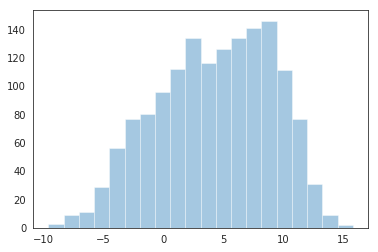

In [0]:
Mean1 = 2  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4 #@param {type:"number"}
Mean2 = 9 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2 #@param {type:"number"}

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

sns.distplot(data, bins=20, kde=False)

In [0]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("done")

done


# A single Gaussion will not fit the data well
Calculating the mean and standard deviation of the dataset shows it does not fit well

Best single Gaussian: μ = 4.3, σ = 4.8


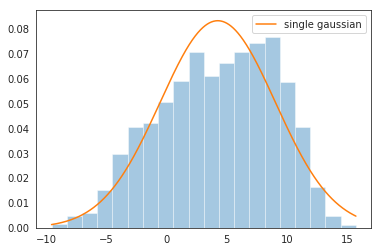

In [0]:
#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))
#fit a single gaussian curve to the data
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [0]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(wp1 + wp2) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done


In [0]:
# See the algorithem in action
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass

 1 Mixture: Gaussian(3.17713, 4.42619), Gaussian(9.51217, 2.40968), mix=0.828)
 1 Mixture: Gaussian(3.13816, 4.49534), Gaussian(9.27539, 2.0743), mix=0.816)
 1 Mixture: Gaussian(3.06868, 4.50025), Gaussian(9.20201, 1.92906), mix=0.805)
 1 Mixture: Gaussian(3.00227, 4.48823), Gaussian(9.17614, 1.86147), mix=0.795)
 1 Mixture: Gaussian(2.9449, 4.47148), Gaussian(9.16648, 1.8321), mix=0.788)


Computing best model with random restarts...

Best Gaussian Mixture : μ = 1.7, σ = 3.9 with μ = 8.6, σ = 2.3


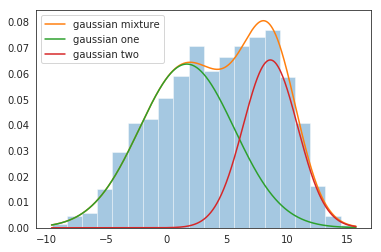

In [0]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();

# sklearn
1. apply general GMM to data


Data 
- patient name 
  - analyte (X1, X2...)
  - time (different)

Try predicting one patient first
1 dimention - only time


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Gaussian 1: μ = 8.5, σ = 2.3, weight = 0.4
Gaussian 2: μ = 1.5, σ = 3.8, weight = 0.6


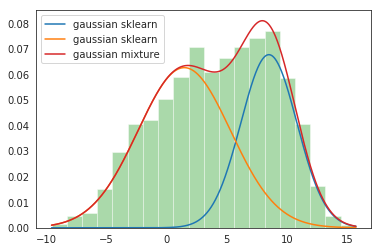

In [0]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2, tol=0.000001)
gmm.fit(np.expand_dims(data, 1)) # Parameters: array-like, shape (n_samples, n_features), 1 dimension dataset so 1 feature
Gaussian_nr = 1
for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format(Gaussian_nr, mu, sd, p))
    g_s = stats.norm(mu, sd).pdf(x) * p
    plt.plot(x, g_s, label='gaussian sklearn');
    Gaussian_nr += 1
sns.distplot(data, bins=20, kde=False, norm_hist=True)
gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x]) #gmm gives log probability, hence the exp() function
plt.plot(x, gmm_sum, label='gaussian mixture');
plt.legend();

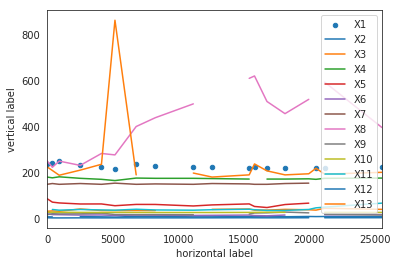

In [0]:
# Try kmeans
# Plot the data with K Means Labels
#from sklearn.cluster import KMeans
#kmeans = KMeans(4, random_state=0)
#labels = kmeans.fit(X).predict(X)


ax = df.plot(kind="scatter", x="time",y="X1", label="X1")
for colname in df.columns[2:]: # ignore time and X1
  df.plot(x="time",y=colname, label=colname, ax=ax)

ax.set_xlabel("horizontal label")
ax.set_ylabel("vertical label")
plt.show()
#plt.scatter(df['time'], df['X1']);

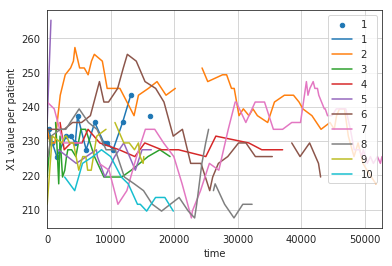

In [0]:
# plot all X1

analyte = "X1"

ax = train[1].plot(kind="scatter", x="time",y=analyte, label="1")
for patient in train: 
  train[patient].plot(x="time",y=analyte, label=patient, ax=ax)
    
ax.set_xlabel("time")
ax.set_ylabel("X1 value per patient")
plt.grid(True)
#plt.ylabel("X1 value per patient")
#plt.xlabel("time")
plt.show()
#plt.scatter(df['time'], df['X1']);

# Try multivariate feature imputation

In [14]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import MissingIndicator
print("import done")

import done


In [31]:
result = {}
imp = IterativeImputer(max_iter=10, random_state=0)

for i in range(1,num): # 1 to 10
  imp.fit(train[i])  
  IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values="NaN", n_nearest_features=None,
                 random_state=0, sample_posterior=False, tol=0.001,
                 verbose=0)
  result_transform = train[i].copy()
  result[i] = pd.DataFrame(imp.transform(result_transform), index = train[i].index, columns = train[i].columns)
  print("patient {} is imputed".format(i))

patient 1 is imputed
patient 2 is imputed
patient 3 is imputed
patient 4 is imputed
patient 5 is imputed
patient 6 is imputed
patient 7 is imputed
patient 8 is imputed
patient 9 is imputed
patient 10 is imputed


# nRMSD
Looks correct in 10 result
should try all 6000... sometime

In [27]:
%%time
# Load CSV using Pandas
baseline = {}
for i in range(1,11): # 1 to 10
    baseline[i] =  pd.read_csv('/gdrive/My Drive/data/AP1/Baseline/Baseline/MICE_train_imputed/' + str(i) + '.csv')


CPU times: user 27.6 ms, sys: 4.18 ms, total: 31.7 ms
Wall time: 48.5 ms


In [0]:
%%time
# calculate all nRMSD
# if in naidx, I = 1, else I = 0
#print(train[1])

numer_sum = 0
denom_sum = 0

# iterate first 1300 rows (first 100 patient)
# first 130 rows for first 10
for i, row in naidx.head(num-1).iterrows():
  #print (row['pt.num'], row['test'], row['i'])
  truth_range = truth[row['pt.num']][row['test']].max() - truth[row['pt.num']][row['test']].min()
  diff = abs(truth[row['pt.num']].at[row['i']-1, row['test']] - train[row['pt.num']].at[row['i']-1, row['test']]) 

  #print(truth[row['pt.num']].at[row['i']-1, row['test']]) # -1 since title row
  numer_sum += (diff / truth_range) ** 2
  denom_sum += 1 
  # should be all NaN since in missing

nRMSD = sqrt(numer_sum/denom_sum)
print(nRMSD)

0.21894270903561114


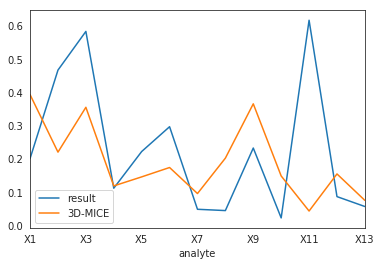

   analyte    result   3D-MICE  Better
0       X1  0.201749  0.393510    True
1       X2  0.467381  0.220729   False
2       X3  0.583609  0.355534   False
3       X4  0.112354  0.119209    True
4       X5  0.222570  0.146350   False
5       X6  0.297142  0.174522   False
6       X7  0.048952  0.096258    True
7       X8  0.045066  0.202682    True
8       X9  0.233062  0.365948    True
9      X10  0.022994  0.149103    True
10     X11  0.617214  0.043722   False
11     X12  0.087053  0.155173    True
12     X13  0.057263  0.075697    True
CPU times: user 330 ms, sys: 160 ms, total: 490 ms
Wall time: 310 ms


In [66]:
%%time
# calculate specific analyte
# specify n for head value, otherwise 6000 (or I should remove head in the end)
# data = baseline or result

def nRMSD(data, a, n=6000) :
  numer_sum = 0
  base_numer_sum = 0
  denom_sum = 0

  # isolate specific analyte
  is_a = naidx['test'] == a
  analyte = naidx[is_a]
  #print(analyte)
  
  for i, row in analyte.head(n).iterrows():
  #print (row['pt.num'], row['test'], row['i'])
    truth_range = truth[row['pt.num']][row['test']].max() - truth[row['pt.num']][row['test']].min()
    diff = abs(truth[row['pt.num']].at[row['i']-1, row['test']] - data[row['pt.num']].at[row['i']-1, row['test']]) 
    base_diff = abs(truth[row['pt.num']].at[row['i']-1, row['test']] - baseline[row['pt.num']].at[row['i']-1, row['test']]) 

    #print(truth[row['pt.num']].at[row['i']-1, row['test']]) # -1 since title row
    numer_sum += (diff / truth_range) ** 2
    base_numer_sum += (base_diff / truth_range) ** 2
    denom_sum += 1 
    # should be all NaN since in missing
    nRMSD_result = sqrt(numer_sum/denom_sum) 
    nRMSD_baseline = sqrt(base_numer_sum/denom_sum)
    better_or_not = True if nRMSD_result < nRMSD_baseline else False
    return [a, nRMSD_result, nRMSD_baseline, better_or_not]


comparison = []
analytes = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13']

for i in analytes:
  res = nRMSD(result, i, 10)
  comparison.append(res)

nRMSD_df = pd.DataFrame(comparison, columns = ['analyte', 'result', '3D-MICE', 'Better'])

nRMSD_df.plot( x="analyte",y=['result', '3D-MICE', 'Better'])
#plt.xticks(analytes)
plt.show()

print(nRMSD_df)

In [50]:
# I am just too lazy to write analytes
hello = []
for i in range(1,14):
  hello.append('X' + str(i))

print(hello)

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13']
